# Emotion classification

## Necessary imports

In [2]:
import os
import json
import random
from itertools import product
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    EarlyStoppingCallback
)
import numpy as np, torch
from torch import nn
from transformers import Trainer, AutoTokenizer, AutoModelForSequenceClassification


## Helper functions

In [3]:
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

In [4]:
def plot_split(dataset, split_name, order):
    df = pd.DataFrame(dataset)
    df['Emotion'] = df['label'].apply(lambda x: labels[x])
    counts = df['Emotion'].value_counts().reindex(order).reset_index()
    counts.columns = ['Emotion','Count']

    sns.set(style="white")
    plt.figure(figsize=(10,6))
    ax = sns.barplot(data=counts, x="Emotion", y="Count", palette="Set2", order=order)
    plt.grid(False)
    for i, r in counts.iterrows():
        ax.text(i, r["Count"]+50, str(r["Count"]), ha='center', va='bottom', fontsize=10)
    plt.title(f"Label Distribution in {split_name} Set")
    plt.xlabel("Emotion"); plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.tight_layout(); plt.show()

## English dataset

### Split dataset

In [5]:
ds_split = load_dataset("dair-ai/emotion", "split")

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
print(len(ds_split['train']))

16000


In [7]:
print(len(ds_split['validation']))

2000


In [8]:
print(len(ds_split['test']))

2000


In [9]:
labels = ds_split['train'].features['label'].names
samples = ds_split['train'][:10]

df = pd.DataFrame({
    "text": samples["text"],
    "label": [labels[label_id] for label_id in samples["label"]]
})

df

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


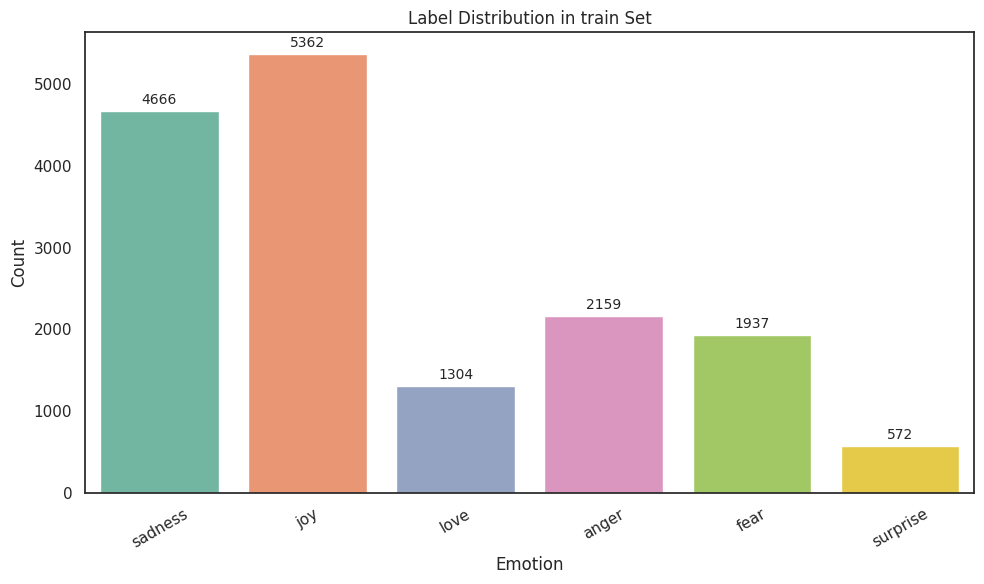

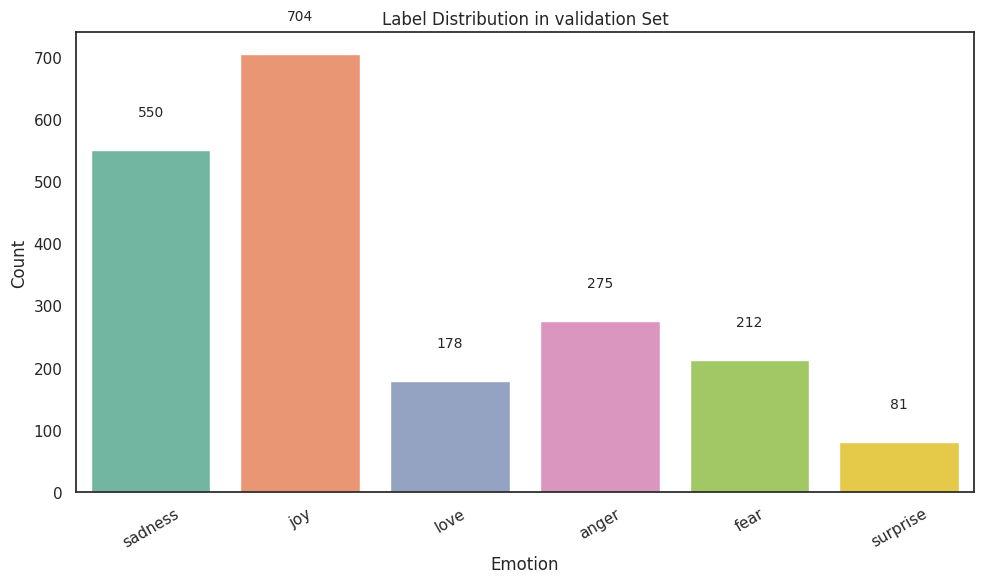

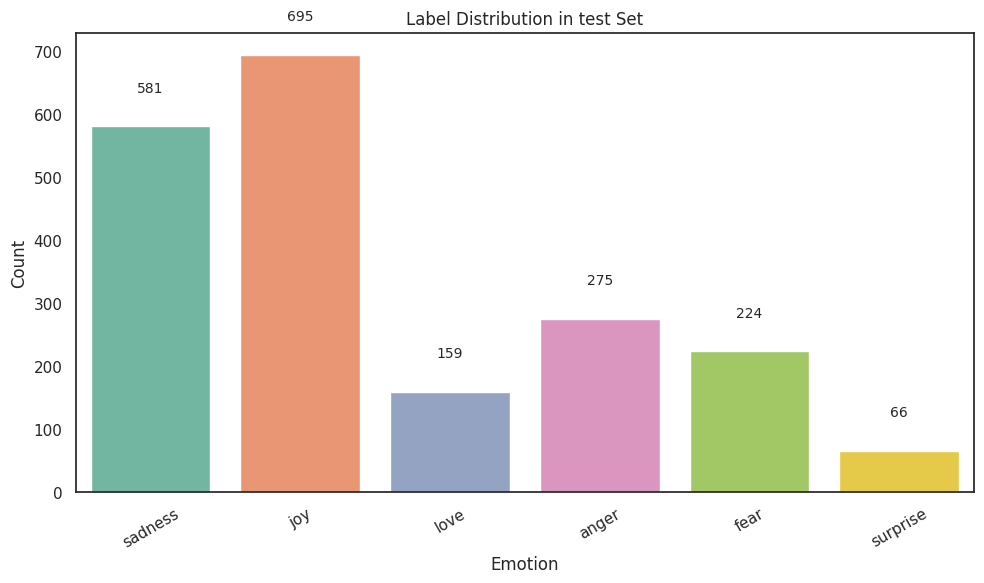

In [12]:
labels = ds_split["train"].features["label"].names
order = labels
for split in ["train", "validation", "test"]:
    plot_split(ds_split[split].to_pandas(), split, order)

### Unsplit dataset

In [14]:
ds_unsplit = load_dataset("dair-ai/emotion", "unsplit")

unsplit/train-00000-of-00001.parquet:   0%|          | 0.00/26.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/416809 [00:00<?, ? examples/s]

In [14]:
print(len(ds_unsplit['train']))

416809


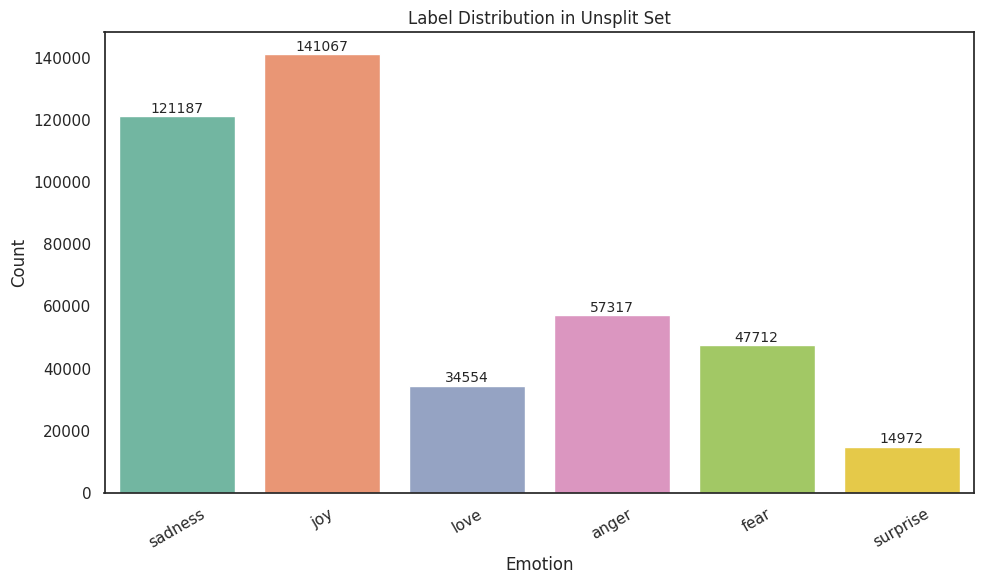

In [15]:
labels = ds_unsplit["train"].features["label"].names
order = labels

plot_split(ds_unsplit["train"].to_pandas(), "Unsplit", order)

### Data preprocessing: balancing the dataset, checking for duplicates, nans, data leakage...

In [17]:
df = pd.DataFrame(ds_unsplit['train'])
labels = ds_unsplit['train'].features['label'].names

In [18]:
balanced_parts = []
rng = np.random.default_rng(seed=45)

for label_id in range(len(labels)):
    available = df[df['label'] == label_id]
    sample_size = rng.integers(9000, 11001)
    sample_size = min(sample_size, len(available))
    class_samples = available.sample(n=sample_size, random_state=42)
    balanced_parts.append(class_samples)

balanced_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['Emotion'] = balanced_df['label'].apply(lambda x: labels[x])


In [19]:
n_total = len(balanced_df)
n_nan_text = balanced_df["text"].isna().sum()
n_nan_label = balanced_df["label"].isna().sum()
short_mask_all = balanced_df["text"].fillna("").str.split().str.len() < 3
n_short_all = short_mask_all.sum()

print({"rows_total": n_total, "nan_text": int(n_nan_text), "nan_label": int(n_nan_label), "short_texts(<3w)": int(n_short_all)})
if n_nan_text or n_nan_label:
    print(balanced_df[balanced_df["text"].isna() | balanced_df["label"].isna()].head(10)[["text","label"]])
if n_short_all:
    print(balanced_df[short_mask_all][["text","label"]])

{'rows_total': 62107, 'nan_text': 0, 'nan_label': 0, 'short_texts(<3w)': 11}
                    text  label
1601              when i      3
2909             nothing      3
3287               blank      1
10510      sometime back      4
33073             a girl      3
33086               once      4
35882               once      3
45624           honestly      3
46767               when      4
55450  never experienced      3
57641      failing examn      0


In [19]:
mask = balanced_df.duplicated(subset=["text"], keep=False)

duplicates = balanced_df[mask].sort_values("text")
print(f"Number of duplicate texts: {mask.sum()}")
print(duplicates[:20])

Number of duplicate texts: 2047
                                                    text  label   Emotion
17059  i accept aswell been in the abominable bearing...      3     anger
50036  i accept aswell been in the abominable bearing...      4      fear
26672  i admit im feeling a bit lot overwhelmed and s...      5  surprise
5377   i admit im feeling a bit lot overwhelmed and s...      4      fear
23403  i after eli kim but feeling that would maybe b...      5  surprise
36469  i after eli kim but feeling that would maybe b...      4      fear
18765  i album format appeals to me the most but afte...      4      fear
46673  i album format appeals to me the most but afte...      5  surprise
29316  i already own quite a few her smoke rose up fo...      4      fear
50683  i already own quite a few her smoke rose up fo...      5  surprise
38168  i also don t feel like that s the face of some...      2      love
2426   i also don t feel like that s the face of some...      1       joy
24856 

In [20]:
balanced_df = balanced_df.dropna(subset=["text","label"]).copy()

In [21]:
balanced_df = balanced_df[balanced_df["text"].fillna("").str.split().str.len() >= 3]

In [22]:
balanced_df = balanced_df.drop_duplicates(subset=["text"]).reset_index(drop=True)

In [23]:
mask = balanced_df.duplicated(subset=["text"], keep=False)

duplicates = balanced_df[mask].sort_values("text")
print(f"Number of duplicate texts: {mask.sum()}")
print(duplicates[:20])

Number of duplicate texts: 0
Empty DataFrame
Columns: [text, label, Emotion]
Index: []


In [24]:
train_df, temp_df = train_test_split(
    balanced_df,
    test_size=0.30,
    stratify=balanced_df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['label'],
    random_state=42
)

splits = {
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True))
}

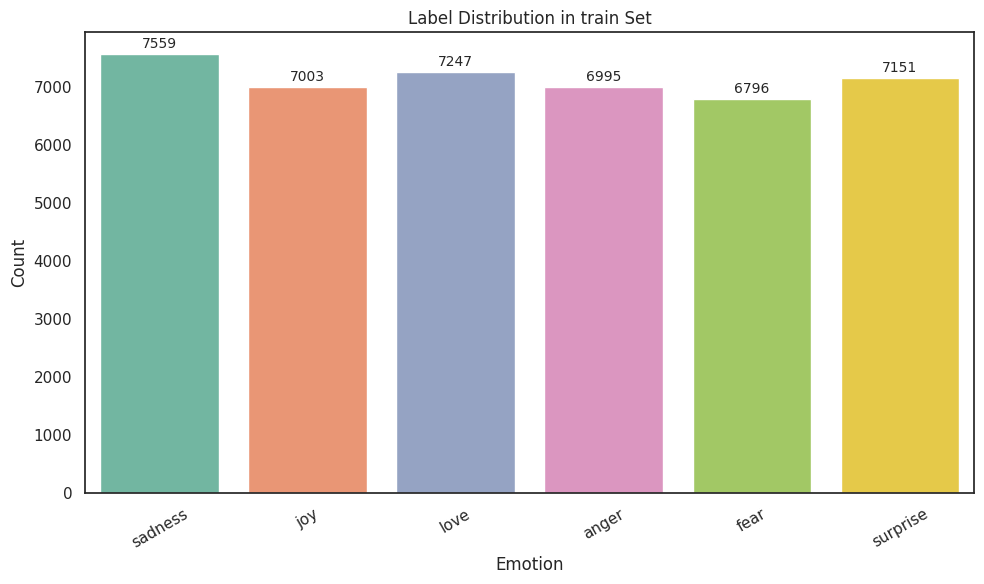

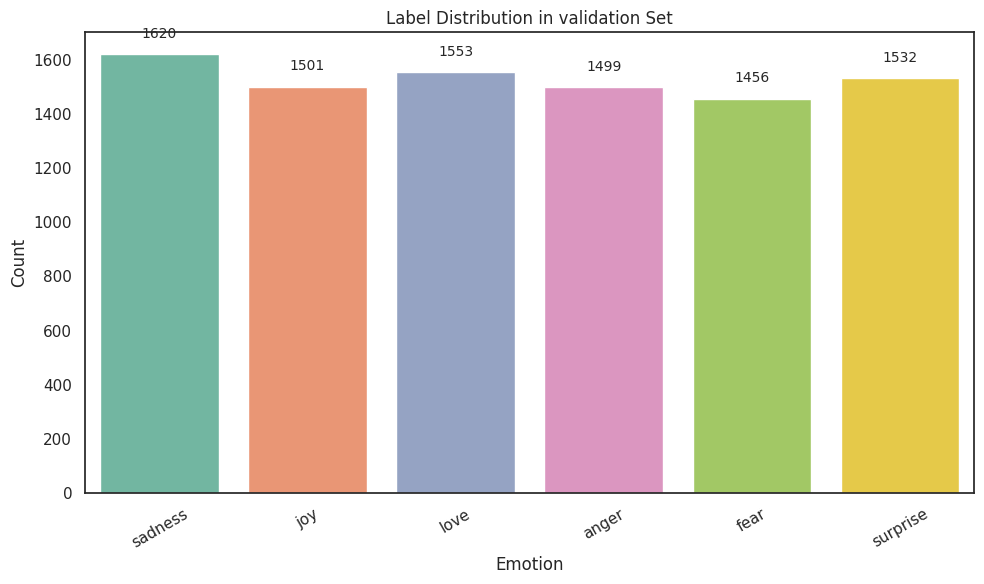

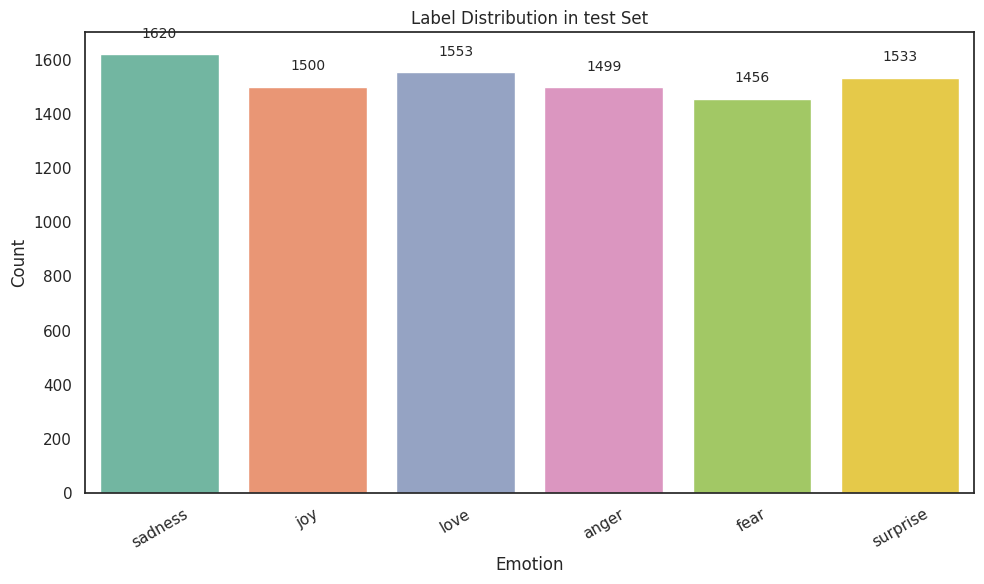

In [25]:
order_labels = labels
for name, ds_ in splits.items():
    plot_split(ds_, name, order_labels)

In [26]:
train_texts = set(train_df["text"])
val_texts = set(val_df["text"])
test_texts = set(test_df["text"])

overlap_tv = train_texts & val_texts
overlap_tt = train_texts & test_texts
overlap_vt = val_texts & test_texts

print({"leak_train_val": len(overlap_tv), "leak_train_test": len(overlap_tt), "leak_val_test": len(overlap_vt)})
if overlap_tv:
    print("train∩val examples:", list(overlap_tv)[:5])
if overlap_tt:
    print("train∩test examples:", list(overlap_tt)[:5])
if overlap_vt:
    print("val∩test examples:", list(overlap_vt)[:5])

assert len(overlap_tv) == 0 and len(overlap_tt) == 0 and len(overlap_vt) == 0, "Split leakage detected"

{'leak_train_val': 0, 'leak_train_test': 0, 'leak_val_test': 0}


## Model training

#### Hugging Face Datasets

In [27]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

labels_list = labels
class_label = ClassLabel(num_classes=len(labels_list), names=labels_list)

In [28]:
def drop_unused(ds):
    cols = [c for c in ds.column_names if c not in ("text","label")]
    return ds.remove_columns(cols)

In [29]:
train_ds = drop_unused(train_ds).cast_column("label", class_label)
val_ds   = drop_unused(val_ds).cast_column("label", class_label)
test_ds  = drop_unused(test_ds).cast_column("label", class_label)

Casting the dataset:   0%|          | 0/42751 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9161 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9161 [00:00<?, ? examples/s]

In [30]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 42751
})

In [31]:
val_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 9161
})

In [32]:
test_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 9161
})

#### Tokenizing

In [33]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
lengths = pd.Series([len(tokenizer(t, add_special_tokens=True)["input_ids"]) for t in balanced_df["text"]])
p95 = int(lengths.quantile(0.95))
p99 = int(lengths.quantile(0.99))
MAX_LEN = min(256, max(128, p99))

print({"p95": p95, "p99": p99, "MAX_LEN": MAX_LEN})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'p95': 46, 'p99': 58, 'MAX_LEN': 128}


In [34]:
def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

In [35]:
train_tok = train_ds.map(tok, batched=True, remove_columns=["text"])
val_tok   = val_ds.map(tok, batched=True, remove_columns=["text"])
test_tok  = test_ds.map(tok, batched=True, remove_columns=["text"])

Map:   0%|          | 0/42751 [00:00<?, ? examples/s]

Map:   0%|          | 0/9161 [00:00<?, ? examples/s]

Map:   0%|          | 0/9161 [00:00<?, ? examples/s]

In [36]:
train_tok[0]

{'label': 1,
 'input_ids': [101,
  1045,
  2215,
  1037,
  3105,
  2073,
  1045,
  2031,
  2061,
  2172,
  2147,
  2000,
  2079,
  9544,
  8231,
  2242,
  2008,
  1045,
  2572,
  13459,
  2055,
  2004,
  4941,
  2000,
  6945,
  6313,
  25120,
  8518,
  2008,
  2012,
  1996,
  2203,
  1997,
  1996,
  2154,
  1045,
  2514,
  1999,
  5737,
  20255,
  4383,
  1998,
  7568,
  2000,
  2272,
  2067,
  1998,
  11147,
  2009,
  1996,
  2279,
  2154,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


#### Model & metrics definitions

In [37]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels_list))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
labels_list

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [40]:
def compute_metrics(eval_pred, label_list=labels_list):
    preds, y = eval_pred
    preds = np.argmax(preds, axis=1)

    per_class_f1 = {
        f"f1_{label_name}": score
        for label_name, score in zip(
            labels_list,
            f1_score(y, preds, average=None, zero_division=0)
        )
    }

    return {
        "accuracy": accuracy_score(y, preds),
        "f1_macro": f1_score(y, preds, average="macro", zero_division=0),
        "precision_macro": precision_score(y, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(y, preds, average="macro", zero_division=0),
        **per_class_f1
    }

#### Training setup

In [41]:
args = TrainingArguments(
    output_dir="./emotion_bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    logging_strategy="steps",
    logging_steps=100,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

In [42]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    processing_class=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)

In [43]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.158600,0.125066,0.956882,0.956348,0.957283,0.956246,0.962643,0.953720,0.965777,0.954852,0.928397,0.972698
2,0.107300,0.110637,0.961904,0.961419,0.962367,0.961432,0.971482,0.960468,0.969602,0.959549,0.934403,0.973007
3,0.090000,0.106911,0.962995,0.962564,0.963451,0.962550,0.972161,0.960825,0.968995,0.963533,0.936244,0.973626


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2004, training_loss=0.21071397162185695, metrics={'train_runtime': 965.7606, 'train_samples_per_second': 132.8, 'train_steps_per_second': 2.075, 'total_flos': 3759649751830104.0, 'train_loss': 0.21071397162185695, 'epoch': 3.0})

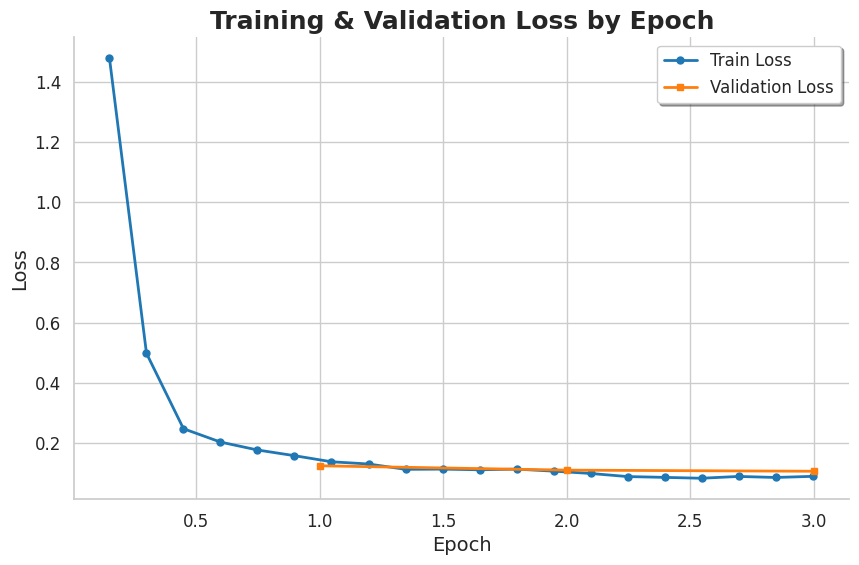

In [44]:
logs = pd.DataFrame(trainer.state.log_history)

train_logs = logs[logs["loss"].notnull()][["epoch", "loss"]]
val_logs = logs[logs["eval_loss"].notnull()][["epoch", "eval_loss"]]

sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss", 
         color="#1f77b4", linewidth=2, marker="o", markersize=5)
plt.plot(val_logs["epoch"], val_logs["eval_loss"], label="Validation Loss", 
         color="#ff7f0e", linewidth=2, marker="s", markersize=5)

plt.title("Training & Validation Loss by Epoch", fontsize=18, fontweight="bold")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=True, shadow=True, fontsize=12)

sns.despine()
plt.show()

In [45]:
# val_metrics = trainer.evaluate(eval_dataset=val_tok)
test_metrics = trainer.evaluate(eval_dataset=test_tok)
trainer.save_model("./emotion_bert/best")
tokenizer.save_pretrained("./emotion_bert/best")
print({"test": test_metrics})

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test': {'eval_loss': 0.10619521141052246, 'eval_accuracy': 0.9635410981333915, 'eval_f1_macro': 0.9631997727099474, 'eval_precision_macro': 0.9642564640363679, 'eval_recall_macro': 0.9632134725747354, 'eval_f1_sadness': 0.9692982456140351, 'eval_f1_joy': 0.9549861495844875, 'eval_f1_love': 0.9681449094316052, 'eval_f1_anger': 0.9657009657009658, 'eval_f1_fear': 0.9477689380837081, 'eval_f1_surprise': 0.9732994278448824, 'eval_runtime': 21.053, 'eval_samples_per_second': 435.139, 'eval_steps_per_second': 3.42, 'epoch': 3.0}}


In [46]:
pred = trainer.predict(test_tok)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=labels_list))
cm = confusion_matrix(y_true, y_pred)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

     sadness       0.98      0.95      0.97      1620
         joy       0.99      0.92      0.95      1500
        love       0.94      1.00      0.97      1553
       anger       0.96      0.97      0.97      1499
        fear       0.95      0.94      0.95      1456
    surprise       0.95      1.00      0.97      1533

    accuracy                           0.96      9161
   macro avg       0.96      0.96      0.96      9161
weighted avg       0.96      0.96      0.96      9161



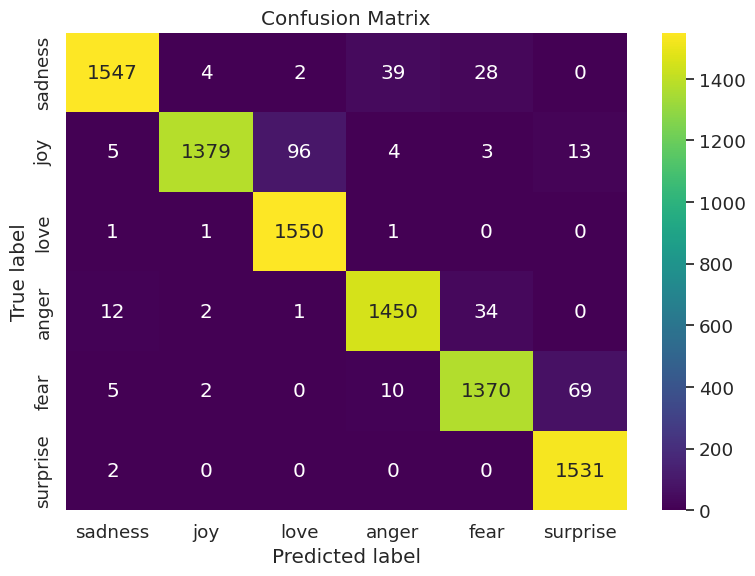

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=labels_list,
    yticklabels=labels_list
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [48]:
def predict_emotion(texts, topk=3):
    if isinstance(texts, str):
        texts = [texts]
    enc = tokenizer(texts, truncation=True, max_length=MAX_LEN, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    topk_idx = np.argsort(-probs, axis=1)[:, :topk]
    results = []
    for i, idxs in enumerate(topk_idx):
        results.append([(labels_list[j], float(probs[i, j])) for j in idxs])
    return results

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
text = "My cat died"
res = predict_emotion(text, topk=3)[0]
print(text)
print(res)
for lbl, p in res:
    print(f"{lbl}: {p:.3f}")

My cat died
[('sadness', 0.9803605675697327), ('anger', 0.014192319475114346), ('joy', 0.002824489725753665)]
sadness: 0.980
anger: 0.014
joy: 0.003


## Choosing the best weight decays and learning rate parameters

In [51]:
def plot_losses(trainer, run_dir, run_name):
    logs = pd.DataFrame(trainer.state.log_history)
    train_logs = (
        logs.loc[logs["loss"].notnull(), ["epoch", "loss"]]
        .dropna()
        .groupby("epoch", as_index=False)
        .mean()
        .sort_values("epoch")
    )
    val_logs = (
        logs.loc[logs["eval_loss"].notnull(), ["epoch", "eval_loss"]]
        .dropna()
        .groupby("epoch", as_index=False)
        .last()
        .sort_values("epoch")
    )
    os.makedirs(os.path.join(run_dir, "plots"), exist_ok=True)
    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))
    if len(train_logs):
        plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss", linewidth=2, marker="o", markersize=4)
    if len(val_logs):
        plt.plot(val_logs["epoch"], val_logs["eval_loss"], label="Validation Loss", linewidth=2, marker="s", markersize=4)
    plt.title("Training & Validation Loss by Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if len(train_logs) or len(val_logs):
        plt.legend()
    sns.despine()
    plt.tight_layout()
    path = os.path.join(run_dir, "plots", f"{run_name}_loss.png")
    plt.savefig(path, dpi=150)
    plt.show()
    train_logs.to_csv(os.path.join(run_dir, "plots", f"{run_name}_train_logs.csv"), index=False)
    val_logs.to_csv(os.path.join(run_dir, "plots", f"{run_name}_val_logs.csv"), index=False)

def plot_confusion_matrix(cm, labels, run_dir, run_name):
    os.makedirs(os.path.join(run_dir, "plots"), exist_ok=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    path = os.path.join(run_dir, "plots", f"{run_name}_confusion_matrix.png")
    plt.savefig(path, dpi=150)
    plt.show()
    # plt.close()

def evaluate_and_save(trainer, test_dataset, labels, run_dir, run_name):
    pred = trainer.predict(test_dataset)
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0)
    with open(os.path.join(run_dir, f"{run_name}_classification_report.json"), "w") as f:
        json.dump(report, f, indent=2)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(run_dir, f"{run_name}_classification_report.csv"))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels, run_dir, run_name)

def strip_prefix(d, prefix="eval_"):
    return {k[len(prefix):]: v for k, v in d.items() if k.startswith(prefix)}

MODEL_NAME = "bert-base-uncased"

ID2LABEL = {i: name for i, name in enumerate(labels_list)}
LABEL2ID = {name: i for i, name in enumerate(labels_list)}
NUM_LABELS = len(labels_list)

def build_model():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        id2label=ID2LABEL,
        label2id=LABEL2ID,
    )

In [52]:
class SaveBestModelCallback(TrainerCallback):
    def __init__(self, tokenizer, metric="eval_f1_macro", greater_is_better=True):
        self.tokenizer = tokenizer
        self.metric = metric
        self.greater = greater_is_better
        self.best = None
        self.best_dir = None
    def on_evaluate(self, args, state, control, **kwargs):
        val = kwargs.get("metrics", {}).get(self.metric)
        if val is None:
            return
        better = (self.best is None) or (val > self.best if self.greater else val < self.best)
        if better:
            self.best = val
            self.best_dir = os.path.join(args.output_dir, "best")
            os.makedirs(self.best_dir, exist_ok=True)
            kwargs["model"].save_pretrained(self.best_dir)
            self.tokenizer.save_pretrained(self.best_dir)
        setattr(state, "best_metric_callback", self.best)
        setattr(state, "best_dir", self.best_dir)


In [55]:
def add_prefix(d, prefix):
    return {f"{prefix}{k}": v for k, v in d.items()}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Running combo 1/9: lr=1e-05, wd=0.01 ===


/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.232300,0.171880,0.948586,0.947934,0.949296,0.947810,0.952322,0.939842,0.956657,0.947861,0.920782,0.970140
2,0.143000,0.128689,0.957756,0.957189,0.958366,0.957251,0.968269,0.953200,0.965517,0.954158,0.930233,0.971755
3,0.119200,0.119508,0.959939,0.959526,0.960460,0.959497,0.967280,0.957476,0.967742,0.958177,0.934111,0.972372
4,0.094600,0.114743,0.961249,0.960834,0.961664,0.960856,0.970856,0.959149,0.968025,0.959596,0.934387,0.972990


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


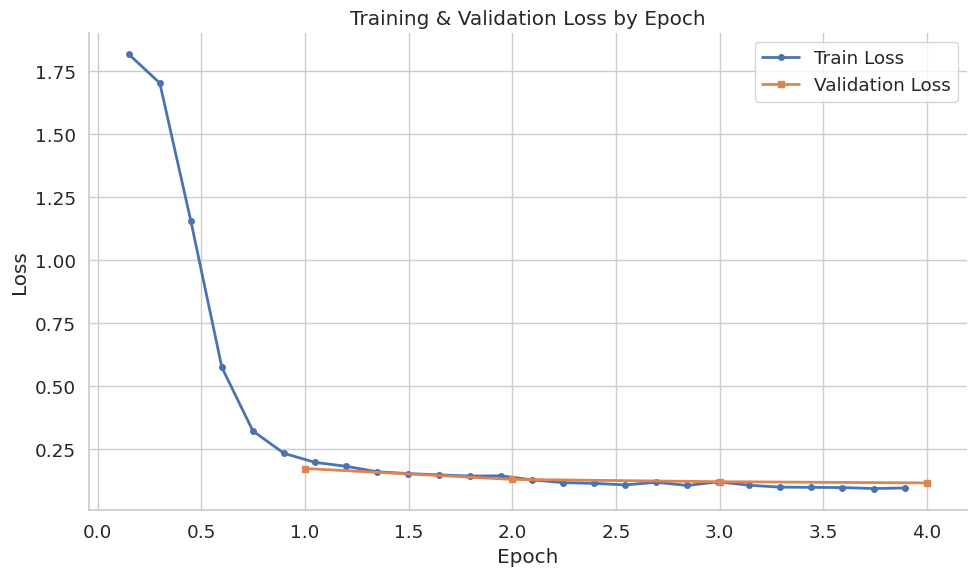

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


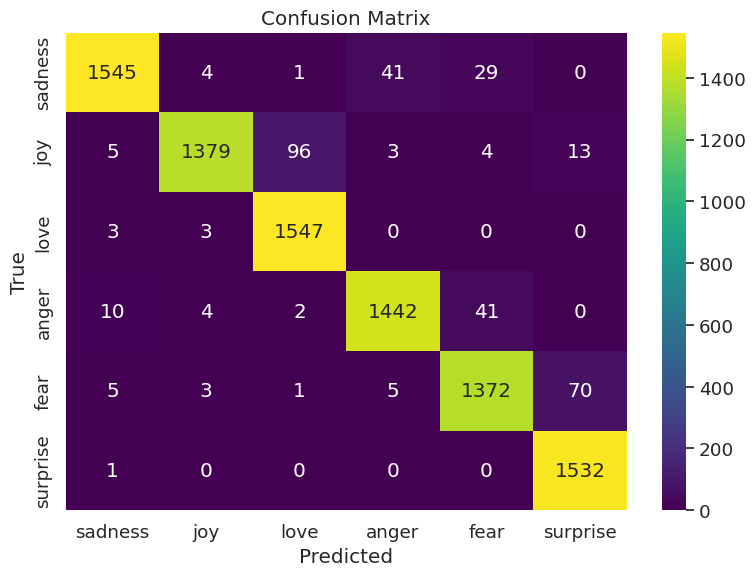

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running combo 2/9: lr=1e-05, wd=0.05 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.233200,0.172153,0.948696,0.948033,0.949472,0.947910,0.952030,0.940083,0.956657,0.947965,0.920669,0.970794
2,0.142900,0.128304,0.957756,0.957197,0.958367,0.957262,0.968553,0.953889,0.965215,0.953816,0.929954,0.971755
3,0.118700,0.119590,0.960048,0.959628,0.960520,0.959608,0.967581,0.957177,0.968045,0.957852,0.934432,0.972681
4,0.094900,0.114743,0.961140,0.960715,0.961548,0.960729,0.970588,0.958104,0.968329,0.959892,0.934387,0.972990


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


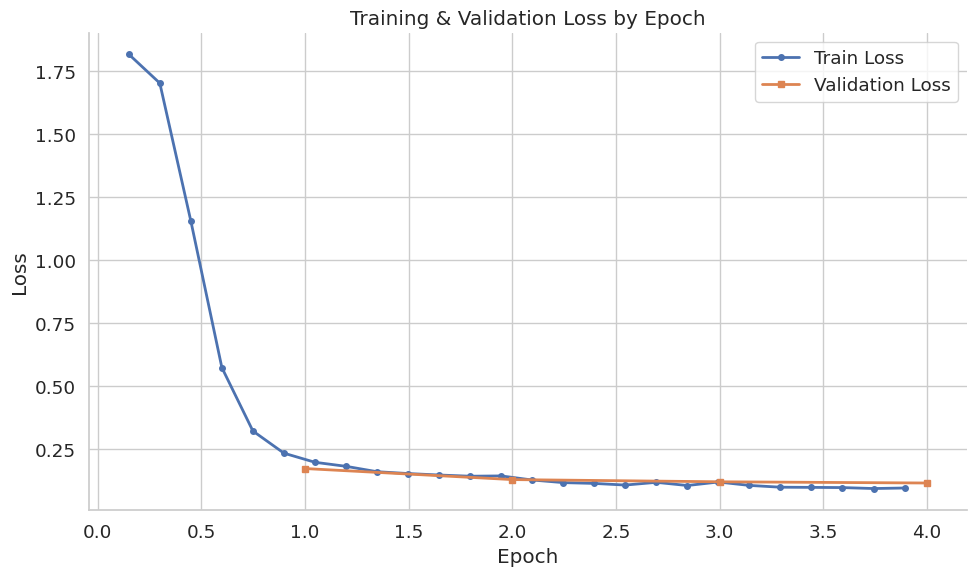

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


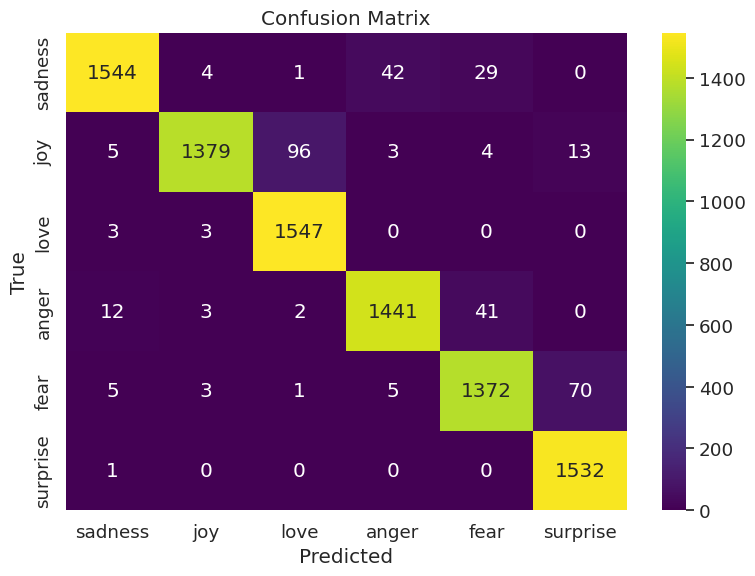

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running combo 3/9: lr=1e-05, wd=0.1 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.233500,0.172474,0.948041,0.947339,0.948875,0.947212,0.951767,0.938705,0.956711,0.947368,0.919343,0.970140
2,0.142600,0.128567,0.958083,0.957535,0.958755,0.957583,0.968269,0.954874,0.965539,0.954471,0.930609,0.971447
3,0.118900,0.119826,0.959393,0.958984,0.959911,0.958954,0.965431,0.957148,0.967742,0.957143,0.934066,0.972372
4,0.095100,0.115001,0.960921,0.960494,0.961324,0.960515,0.970570,0.957775,0.968025,0.959218,0.934387,0.972990


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


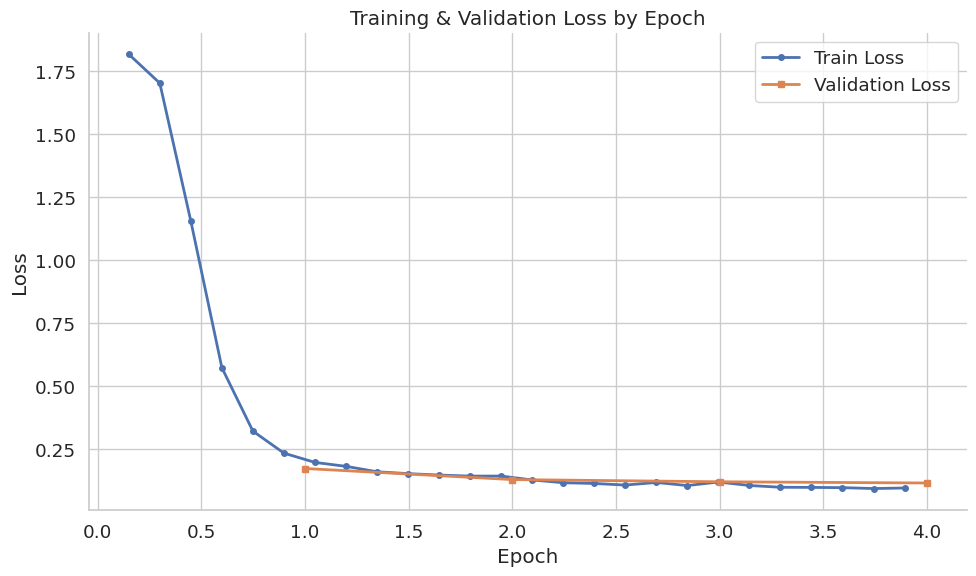

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


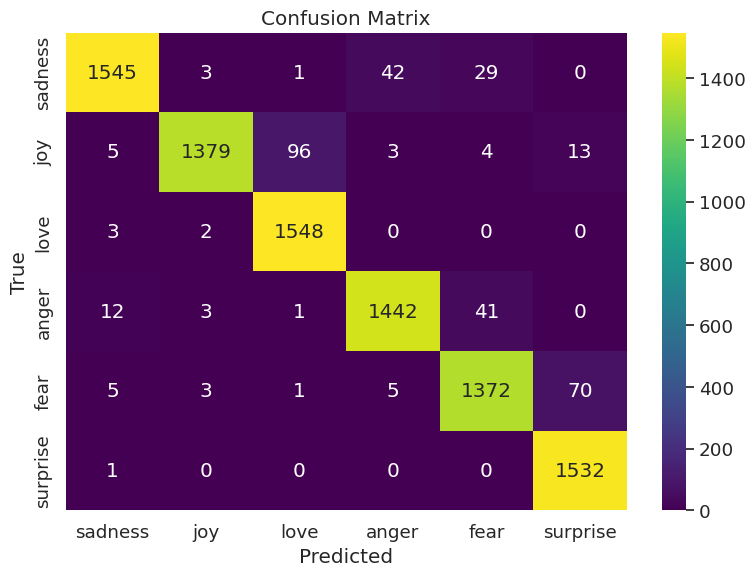

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Running combo 4/9: lr=2e-05, wd=0.01 ===


/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.167700,0.144142,0.954808,0.954285,0.955194,0.954312,0.963357,0.943667,0.960125,0.957633,0.929194,0.971737
2,0.111100,0.113815,0.960921,0.960378,0.961449,0.960355,0.970340,0.959780,0.968995,0.958995,0.931786,0.972372
3,0.098000,0.111773,0.960812,0.960398,0.961314,0.960362,0.968224,0.959177,0.968691,0.956935,0.936683,0.972681
4,0.075700,0.110242,0.963323,0.962931,0.963817,0.962928,0.972144,0.960413,0.968975,0.964824,0.937931,0.973299


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


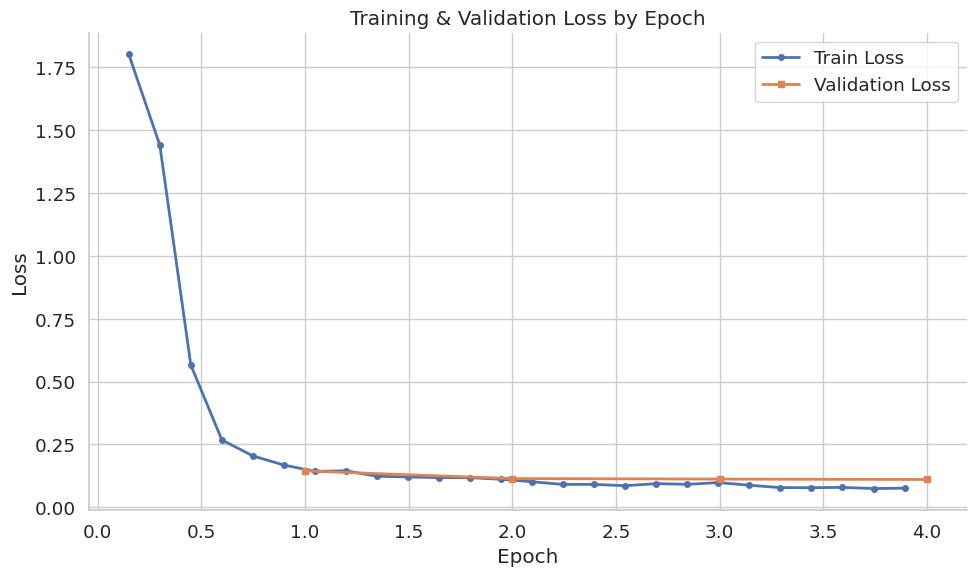

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


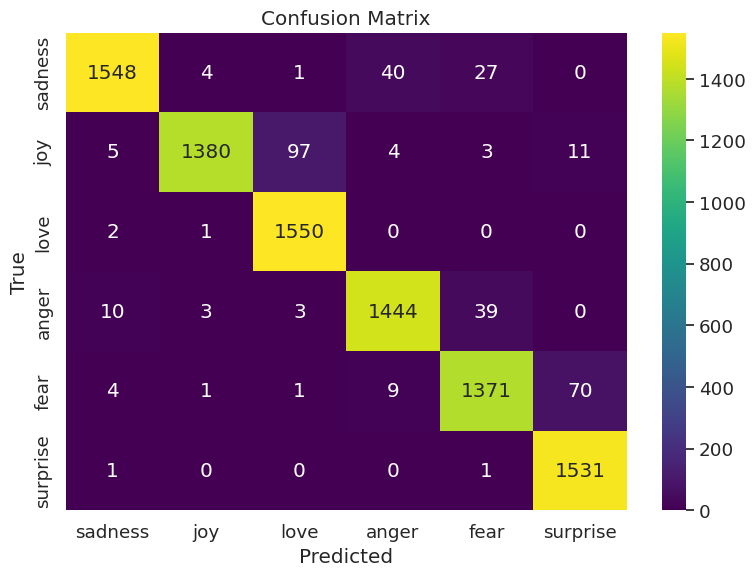

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Running combo 5/9: lr=2e-05, wd=0.05 ===


/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.170000,0.140170,0.955573,0.955044,0.955911,0.955052,0.962570,0.943912,0.962523,0.958040,0.930866,0.972355
2,0.110900,0.115695,0.961030,0.960529,0.961548,0.960518,0.970947,0.957241,0.967742,0.960531,0.934031,0.972681
3,0.096000,0.114461,0.959830,0.959404,0.960237,0.959370,0.966418,0.957177,0.968005,0.955254,0.936273,0.973299
4,0.075000,0.109900,0.962340,0.961935,0.962840,0.961927,0.971250,0.958980,0.968348,0.962739,0.936683,0.973609


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


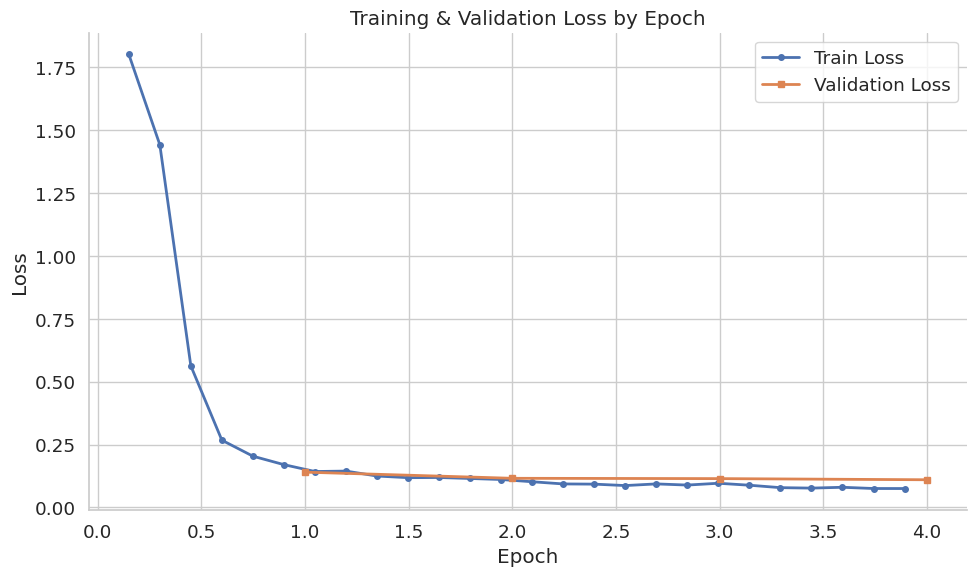

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


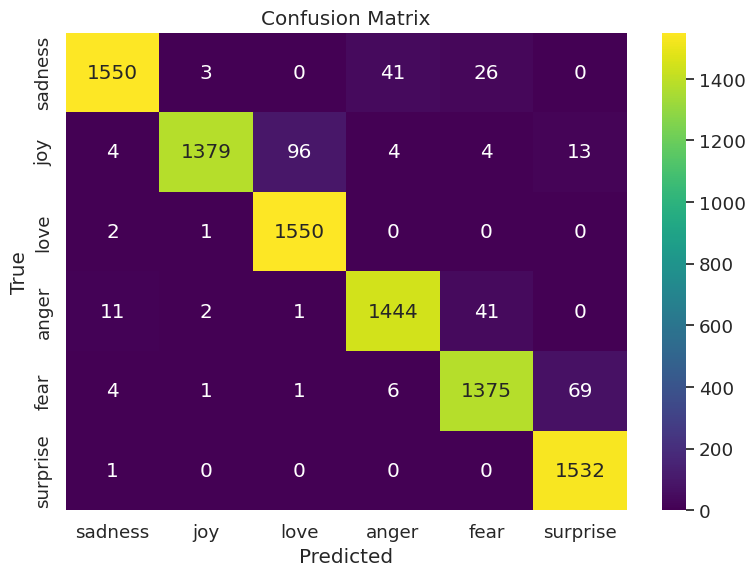

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running combo 6/9: lr=2e-05, wd=0.1 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.167900,0.141472,0.954699,0.954194,0.955204,0.954156,0.960149,0.946863,0.960748,0.956639,0.929046,0.971719
2,0.110900,0.112220,0.961467,0.961022,0.961973,0.961002,0.970322,0.958649,0.968065,0.961230,0.935182,0.972681
3,0.095600,0.109932,0.960594,0.960183,0.961134,0.960116,0.966760,0.960522,0.968995,0.955548,0.936595,0.972681
4,0.075700,0.106948,0.963432,0.963041,0.963884,0.963052,0.971500,0.960110,0.969583,0.966510,0.937241,0.973299


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


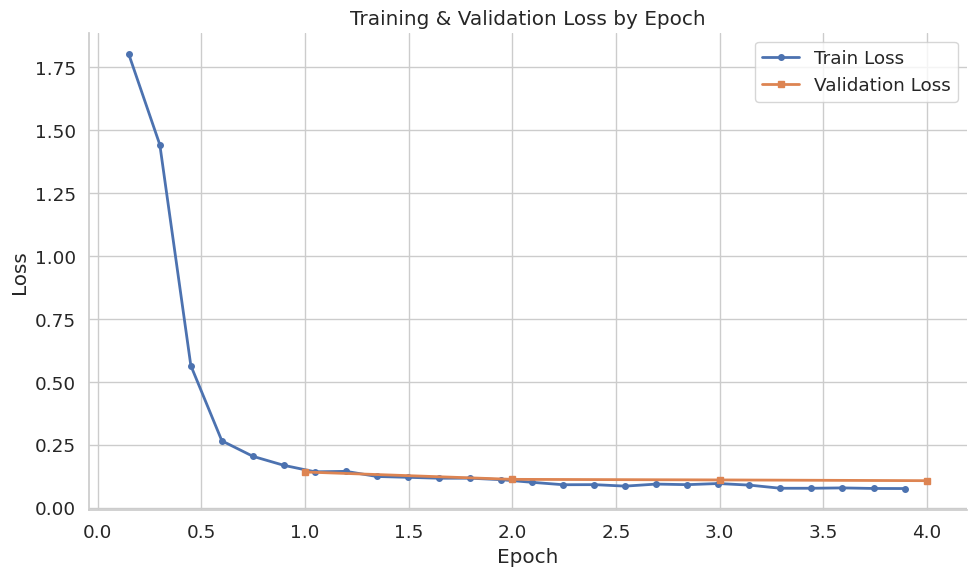

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


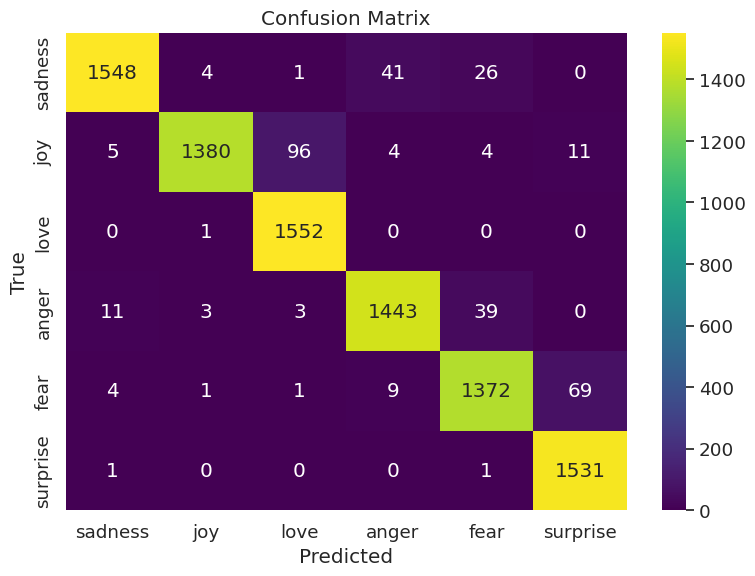

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running combo 7/9: lr=5e-05, wd=0.01 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.146800,0.126008,0.958629,0.958139,0.958862,0.958213,0.970135,0.949406,0.967480,0.956964,0.933150,0.971701
2,0.101100,0.096626,0.964414,0.963965,0.964872,0.964024,0.977008,0.960798,0.969583,0.964924,0.937543,0.973935
3,0.090500,0.103252,0.964305,0.963939,0.964803,0.963946,0.973973,0.961591,0.970551,0.964912,0.939924,0.972681
4,0.072400,0.110408,0.963978,0.963584,0.964386,0.963556,0.972517,0.962938,0.969545,0.963807,0.938451,0.974245


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


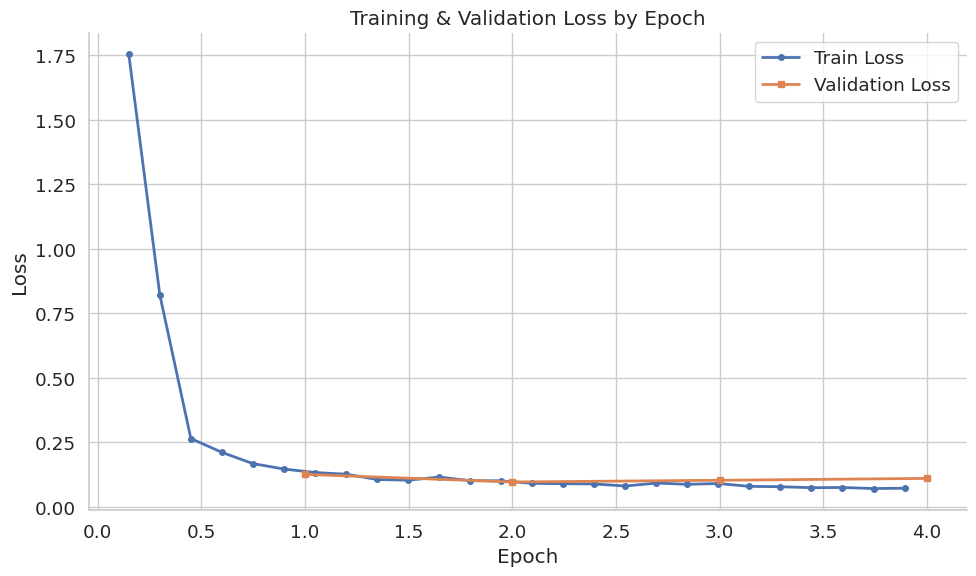

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


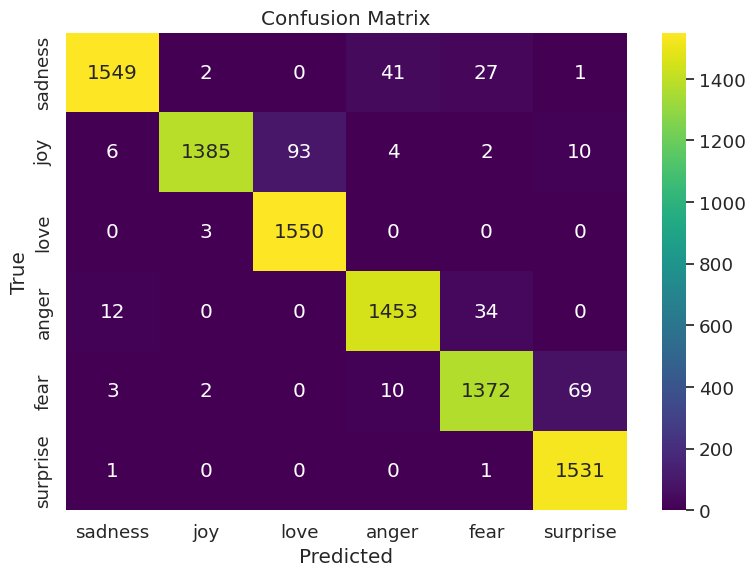

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running combo 8/9: lr=5e-05, wd=0.05 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.150800,0.120594,0.958520,0.958062,0.958896,0.958162,0.968474,0.949129,0.965066,0.957490,0.934895,0.973316
2,0.105200,0.101435,0.963541,0.963134,0.964097,0.963194,0.973858,0.961379,0.970588,0.963260,0.936404,0.973316
3,0.090900,0.109168,0.961358,0.960916,0.961779,0.960832,0.967122,0.960301,0.970514,0.961708,0.932549,0.973299
4,0.071100,0.112121,0.963650,0.963258,0.964013,0.963261,0.970588,0.961288,0.969868,0.966209,0.937673,0.973919


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


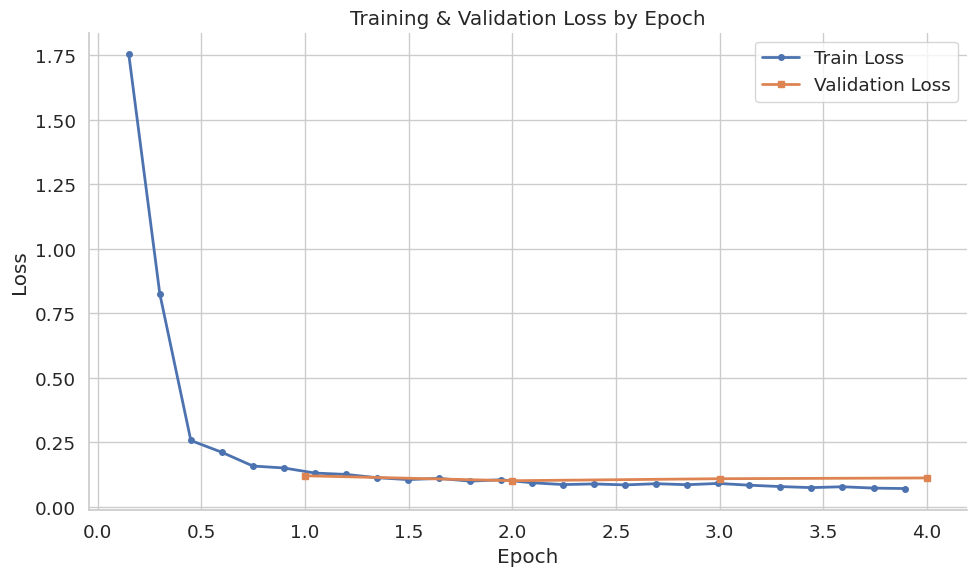

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


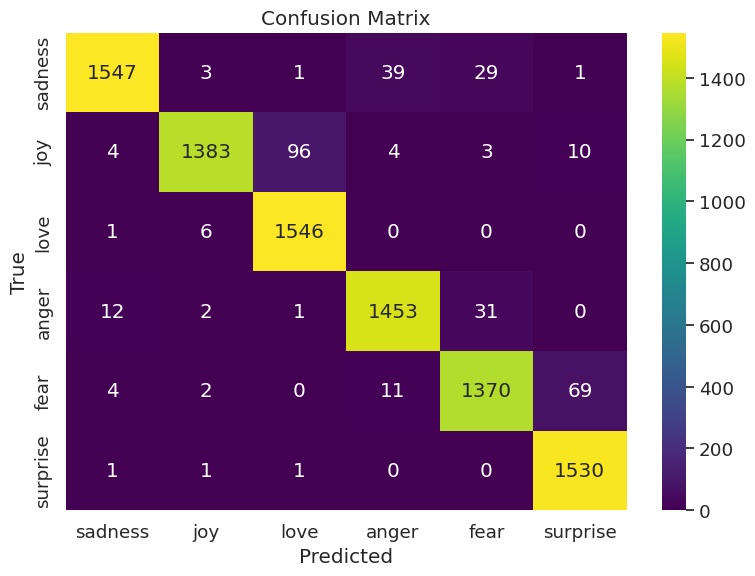

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running combo 9/9: lr=5e-05, wd=0.1 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/44810182.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Sadness,F1 Joy,F1 Love,F1 Anger,F1 Fear,F1 Surprise
1,0.149900,0.131243,0.957428,0.956939,0.957590,0.957014,0.965820,0.947903,0.967378,0.955842,0.932320,0.972372
2,0.102700,0.097766,0.965397,0.964965,0.965872,0.965017,0.976686,0.963243,0.971196,0.967142,0.937587,0.973935
3,0.090100,0.108157,0.963214,0.962815,0.963609,0.962798,0.969413,0.959316,0.971482,0.963839,0.938902,0.973935
4,0.072500,0.116262,0.962995,0.962559,0.963412,0.962562,0.970588,0.960852,0.970892,0.963509,0.935596,0.973919


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


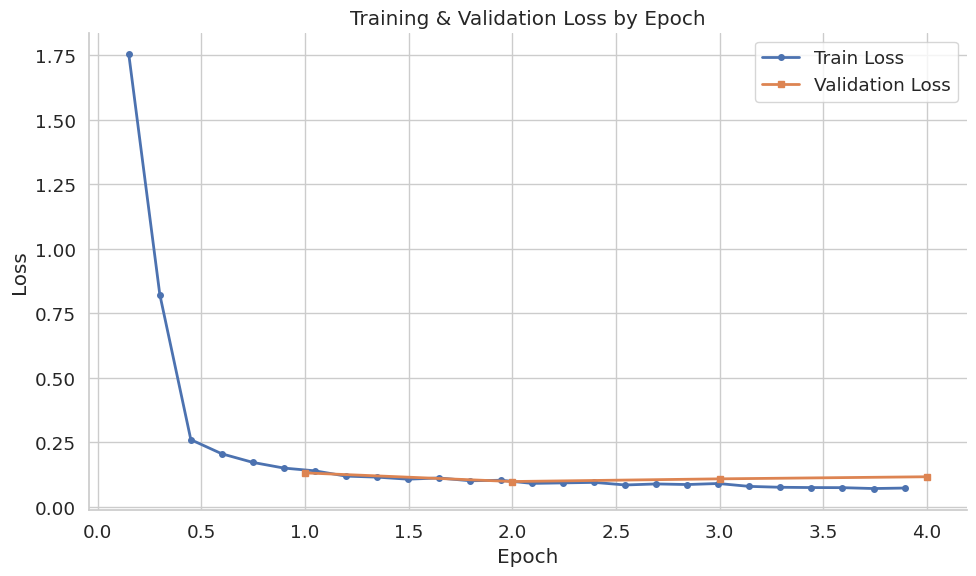

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


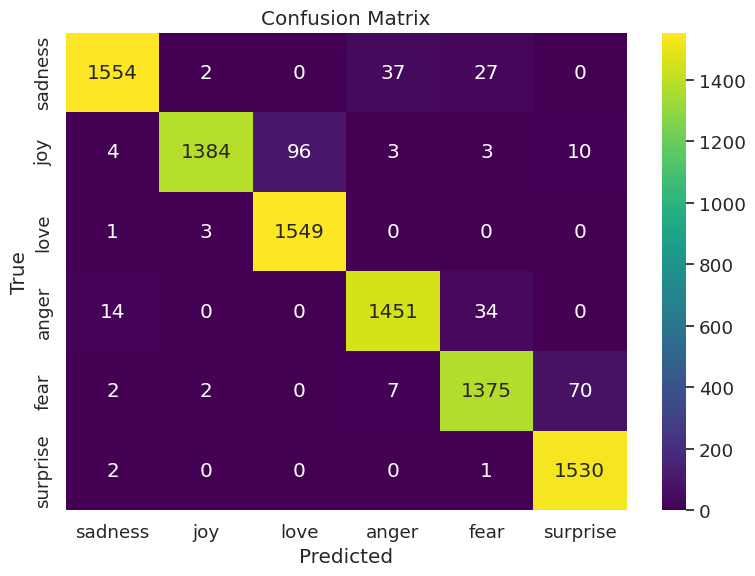

/tmp/ipykernel_36/44810182.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/tmp/ipykernel_36/44810182.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_eval_trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [57]:
learning_rates = [1e-5, 2e-5, 5e-5]
weight_decays = [0.01, 0.05, 0.1]
records = []

combos = list(product(learning_rates, weight_decays))
total = len(combos)

for idx, (lr, wd) in enumerate(combos, start=1):
    print(f"\n=== Running combo {idx}/{total}: lr={lr}, wd={wd} ===")

    run_name = f"lr{lr}_wd{wd}"
    out_dir = f"./emotion_bert_{run_name}"

    args = TrainingArguments(
        output_dir=out_dir,
        eval_strategy="epoch",
        save_strategy="no",
        save_total_limit=1,
        load_best_model_at_end=False,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        learning_rate=lr,
        num_train_epochs=4,
        weight_decay=wd,
        lr_scheduler_type="linear",
        warmup_ratio=0.1,
        logging_strategy="steps",
        logging_steps=100,
        seed=42,
        fp16=torch.cuda.is_available(),
        report_to="none",
        disable_tqdm=False
    )

    cb = SaveBestModelCallback(tokenizer=tokenizer, metric="eval_f1_macro", greater_is_better=True)

    trainer = Trainer(
        model=build_model(),
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        data_collator=collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[cb]
    )

    trainer.train()

    val_metrics = strip_prefix(trainer.evaluate(), "eval_")
    plot_losses(trainer, out_dir, run_name)
    evaluate_and_save(trainer, test_tok, labels_list, out_dir, run_name)

    final_dir = os.path.join(out_dir, "final")
    os.makedirs(final_dir, exist_ok=True)
    trainer.save_model(final_dir)
    tokenizer.save_pretrained(final_dir)

    best_dir = getattr(trainer.state, "best_dir", None)
    best_val_f1 = getattr(trainer.state, "best_metric_callback", None)
    final_val_f1 = val_metrics.get("f1_macro", None)

    final_model = AutoModelForSequenceClassification.from_pretrained(final_dir)
    final_eval_trainer = Trainer(
        model=final_model,
        args=args,
        eval_dataset=test_tok,
        data_collator=collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    final_test_metrics = strip_prefix(final_eval_trainer.evaluate(), "eval_")

    if best_dir is not None and os.path.isdir(best_dir):
        best_model = AutoModelForSequenceClassification.from_pretrained(best_dir)
        best_eval_trainer = Trainer(
            model=best_model,
            args=args,
            eval_dataset=test_tok,
            data_collator=collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        best_test_metrics = strip_prefix(best_eval_trainer.evaluate(), "eval_")
    else:
        best_test_metrics = {}

    records.append({
        "learning_rate": lr,
        "weight_decay": wd,
        "best_dir": best_dir,
        "final_dir": final_dir,
        "best_val_f1": best_val_f1,
        "final_val_f1": final_val_f1,
        **add_prefix(val_metrics, "val_"),
        **add_prefix(best_test_metrics, "test_best_"),
        **add_prefix(final_test_metrics, "test_final_"),
    })

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [59]:
df = pd.DataFrame(records)

for col in ["test_best_f1_macro", "test_final_f1_macro", "best_val_f1", "final_val_f1"]:
    if col not in df.columns:
        df[col] = np.nan

df = df.sort_values(
    by=["test_best_f1_macro", "test_final_f1_macro", "best_val_f1", "final_val_f1"],
    ascending=False,
    na_position="last"
).reset_index(drop=True)

df.to_csv("grid_results.csv", index=False)

In [60]:
df

,learning_rate,weight_decay,best_dir,final_dir,best_val_f1,final_val_f1,val_loss,val_accuracy,val_f1_macro,val_precision_macro,...,test_final_recall_macro,test_final_f1_sadness,test_final_f1_joy,test_final_f1_love,test_final_f1_anger,test_final_f1_fear,test_final_f1_surprise,test_final_runtime,test_final_samples_per_second,test_final_steps_per_second
0,0.00005,0.10,./emotion_bert_lr5e-05_wd0.1/best,./emotion_bert_lr5e-05_wd0.1/final,0.964965,0.962559,0.116262,0.962995,0.962559,0.963412,...,0.964957,0.972161,0.957454,0.968730,0.968302,0.949586,0.973592,20.9305,437.687,3.440
1,0.00005,0.01,./emotion_bert_lr5e-05_wd0.01/best,./emotion_bert_lr5e-05_wd0.01/final,0.963965,0.963584,0.110408,0.963978,0.963584,0.964386,...,0.964648,0.970856,0.957815,0.969962,0.966412,0.948824,0.973919,20.9896,436.454,3.430
2,0.00002,0.05,./emotion_bert_lr2e-05_wd0.05/best,./emotion_bert_lr2e-05_wd0.05/final,0.961935,0.961935,0.109900,0.962340,0.961935,0.962840,...,0.963536,0.971178,0.955648,0.968447,0.964596,0.947622,0.973626,20.9489,437.303,3.437
3,0.00005,0.05,./emotion_bert_lr5e-05_wd0.05/best,./emotion_bert_lr5e-05_wd0.05/final,0.963258,0.963258,0.112121,0.963650,0.963258,0.964013,...,0.963453,0.970210,0.954781,0.966854,0.966733,0.948425,0.973592,21.0388,435.434,3.422
4,0.00002,0.10,./emotion_bert_lr2e-05_wd0.1/best,./emotion_bert_lr2e-05_wd0.1/final,0.963041,0.963041,0.106948,0.963432,0.963041,0.963884,...,0.963093,0.970837,0.955348,0.968185,0.963284,0.946860,0.973919,20.8917,438.498,3.446
5,0.00002,0.01,./emotion_bert_lr2e-05_wd0.01/best,./emotion_bert_lr2e-05_wd0.01/final,0.962931,0.962931,0.110242,0.963323,0.962931,0.963817,...,0.962875,0.970533,0.955348,0.967239,0.963952,0.946496,0.973609,20.9914,436.418,3.430
6,0.00001,0.10,./emotion_bert_lr1e-05_wd0.1/best,./emotion_bert_lr1e-05_wd0.1/final,0.960494,0.960494,0.115001,0.960921,0.960494,0.961324,...,0.962241,0.968348,0.954325,0.967500,0.964226,0.945555,0.973316,20.8623,439.118,3.451
7,0.00001,0.01,./emotion_bert_lr1e-05_wd0.01/best,./emotion_bert_lr1e-05_wd0.01/final,0.960834,0.960834,0.114743,0.961249,0.960834,0.961664,...,0.962134,0.968956,0.953336,0.966875,0.964548,0.945555,0.973316,20.9416,437.454,3.438
8,0.00001,0.05,./emotion_bert_lr1e-05_wd0.05/best,./emotion_bert_lr1e-05_wd0.05/final,0.960715,0.960715,0.114743,0.961140,0.960715,0.961548,...,0.961920,0.968025,0.953665,0.966875,0.963880,0.945555,0.973316,21.0521,435.158,3.420


In [68]:
df.to_csv("/kaggle/working/grid_results.csv", index=False)

## Ukrainian dataset(additional task)

In [64]:
sns.set(style="white")
set_seed(42)

In [67]:
ua_ds_split = load_dataset("ukr-detect/ukr-emotions-binary")
splits = list(ua_ds_split.keys())
feat_names = list(ua_ds_split[splits[0]].features.keys())
label_cols = [c for c in feat_names if c not in {"id","text"}]
labels_ua = label_cols

In [68]:
def split_stats(ds):
    df = pd.DataFrame(ds)
    s = df[label_cols].sum(axis=1)
    return {"rows": len(df), "none": int((s==0).sum()), "single": int((s==1).sum()), "multi": int((s>1).sum())}

In [69]:
sizes = {k: len(ua_ds_split[k]) for k in splits}
stats = {k: split_stats(ua_ds_split[k]) for k in splits}

In [70]:
sizes

{'train': 2466, 'validation': 249, 'test': 2234}

In [71]:
stats

{'train': {'rows': 2466, 'none': 1230, 'single': 1177, 'multi': 59},
 'validation': {'rows': 249, 'none': 123, 'single': 114, 'multi': 12},
 'test': {'rows': 2234, 'none': 1108, 'single': 1023, 'multi': 103}}

In [72]:
def label_distribution(ds):
    df = pd.DataFrame(ds)
    return df[label_cols].sum().astype(int).sort_values(ascending=False).to_dict()

In [73]:
dists = {k: label_distribution(ua_ds_split[k]) for k in splits}

In [74]:
dists

{'train': {'Joy': 412,
  'Sadness': 333,
  'Surprise': 196,
  'Fear': 172,
  'Anger': 98,
  'Disgust': 86},
 'validation': {'Joy': 41,
  'Sadness': 34,
  'Surprise': 25,
  'Fear': 17,
  'Anger': 12,
  'Disgust': 9},
 'test': {'Joy': 368,
  'Sadness': 298,
  'Surprise': 252,
  'Fear': 151,
  'Anger': 99,
  'Disgust': 79}}

In [75]:
def to_single_label_df(ds):
    df = pd.DataFrame(ds).copy()
    s = df[label_cols].sum(axis=1)
    df = df[s==1].reset_index(drop=True)
    idx = df[label_cols].values.argmax(axis=1)
    df["label"] = idx
    return df[["text","label"]]

In [76]:
ua_single = {k: to_single_label_df(ua_ds_split[k]) for k in splits}

In [77]:
ua_single

{'train':                                                    text  label
 0     вже майже час слухаю співи  , це справді шикар...      0
 1     нарешті вони всі знайшли своїх господарів)) На...      0
 2        RT : княгині, сьогодні ваш день, зі святом! ;)      0
 3         Одну тількино зустріла))) Таке миле творіння.      0
 4          Іноді навіть такі дрібниці радують\n#хфактор      0
 ...                                                 ...    ...
 1172                    звідки ти це так швидко знаєш?)      5
 1173                   На шо він сказав, що не страшно.      5
 1174  - нам, будь ласка, окремі рахунки\n- та я вже ...      5
 1175  Те шо відбувається зараз в Москві, це тупо дик...      5
 1176             Дивно, бо там навіть модель відмічена)      5
 
 [1177 rows x 2 columns],
 'validation':                                                   text  label
 0     ранок був похмурий. . .я піднімала всім настр...      0
 1              гнівних твітів я вже дні з 3 не писала)

In [78]:
def dq_report(df):
    n = len(df)
    n_nan_text = int(df["text"].isna().sum())
    n_nan_label = int(df["label"].isna().sum())
    short_mask = df["text"].fillna("").str.split().str.len() < 3
    n_short = int(short_mask.sum())
    dup_mask = df.duplicated(subset=["text"], keep=False)
    n_dup = int(dup_mask.sum())
    return {"rows": n, "nan_text": n_nan_text, "nan_label": n_nan_label, "short_texts(<3w)": n_short, "duplicate_text_rows": n_dup}

In [79]:
dq_before = {k: dq_report(ua_single[k]) for k in splits}

In [80]:
dq_before

{'train': {'rows': 1177,
  'nan_text': 0,
  'nan_label': 0,
  'short_texts(<3w)': 0,
  'duplicate_text_rows': 0},
 'validation': {'rows': 114,
  'nan_text': 0,
  'nan_label': 0,
  'short_texts(<3w)': 0,
  'duplicate_text_rows': 0},
 'test': {'rows': 1023,
  'nan_text': 0,
  'nan_label': 0,
  'short_texts(<3w)': 0,
  'duplicate_text_rows': 0}}

In [81]:
def plot_counts(df, title, order):
    c = df["label"].value_counts().reindex(range(len(order))).fillna(0).astype(int)
    counts = pd.DataFrame({"Emotion": order, "Count": c.values})
    plt.figure(figsize=(8,5))
    ax = sns.barplot(data=counts, x="Emotion", y="Count", palette="Set2", order=order)
    plt.grid(False)
    for i, r in counts.iterrows():
        ax.text(i, r["Count"]+max(3, int(0.01*max(1, counts["Count"].max()))), str(r["Count"]), ha="center", va="bottom", fontsize=10)
    plt.title(title); plt.xlabel("Emotion"); plt.ylabel("Count"); plt.xticks(rotation=20)
    plt.tight_layout(); plt.show()

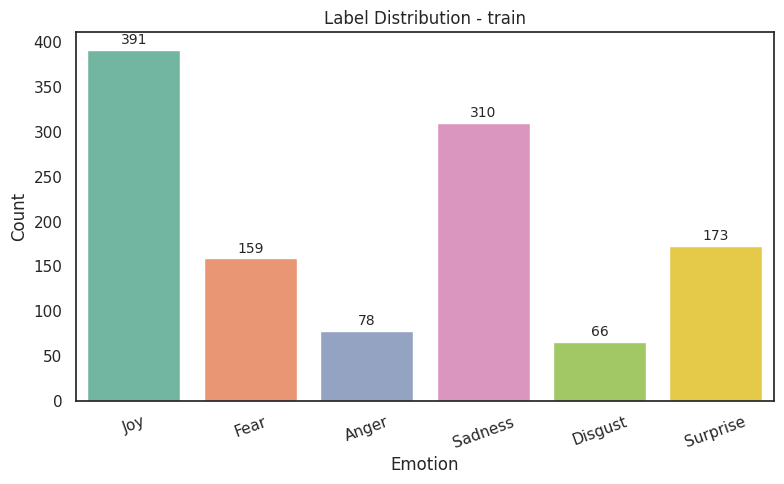

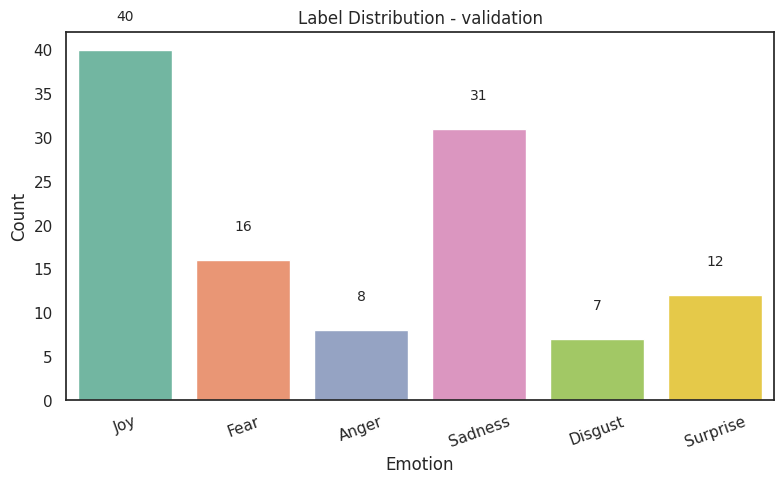

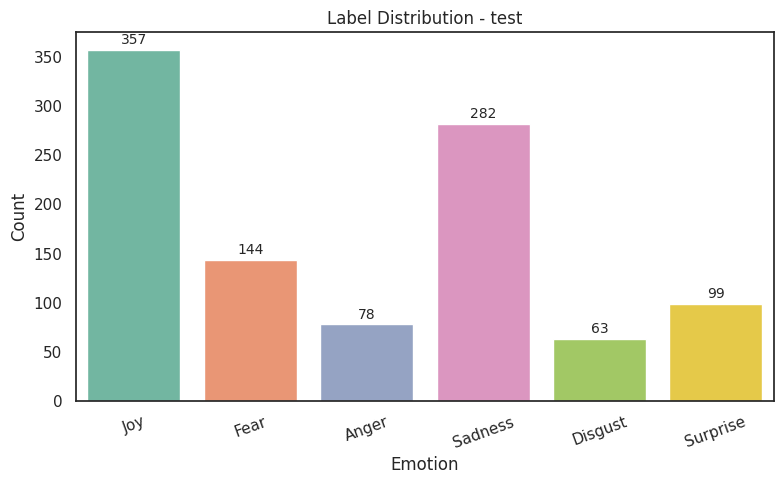

In [82]:
for k in splits:
    plot_counts(ua_single[k], f"Label Distribution - {k}", labels_ua)

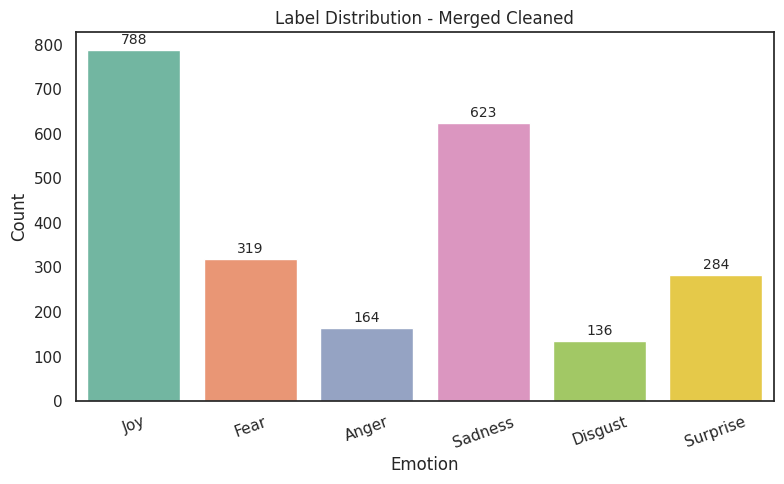

In [85]:
merged = pd.concat([ua_single[k] for k in splits], ignore_index=True)
merged = merged.drop_duplicates(subset=["text"]).reset_index(drop=True)

plot_counts(merged, "Label Distribution - Merged Cleaned", labels_ua)

In [86]:
train_df, temp_df = train_test_split(merged, test_size=0.30, stratify=merged["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)

In [87]:
def leak_report(a, b, aname, bname):
    ta, tb = set(a["text"]), set(b["text"])
    return {f"leak_{aname}_{bname}": len(ta & tb)}

In [88]:
leaks = {}
leaks.update(leak_report(train_df, val_df, "train", "val"))
leaks.update(leak_report(train_df, test_df, "train", "test"))
leaks.update(leak_report(val_df, test_df, "val", "test"))

In [89]:
leaks

{'leak_train_val': 0, 'leak_train_test': 0, 'leak_val_test': 0}

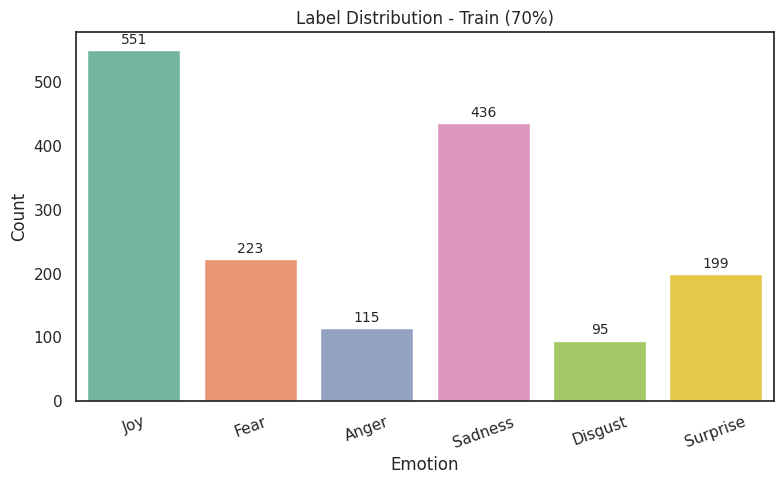

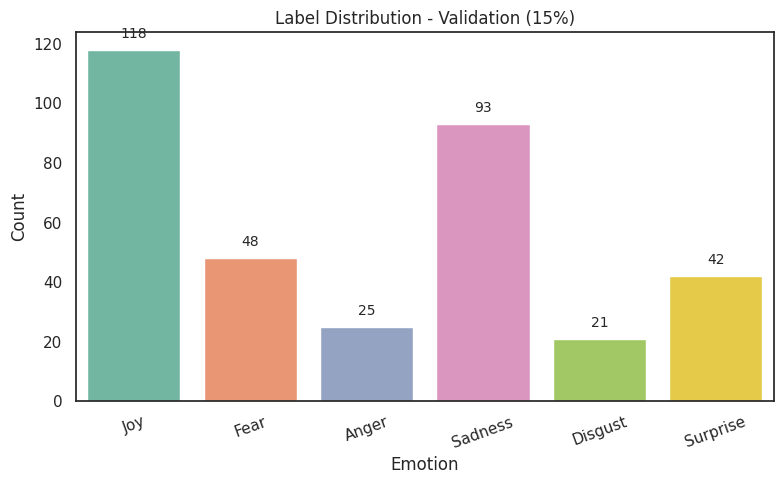

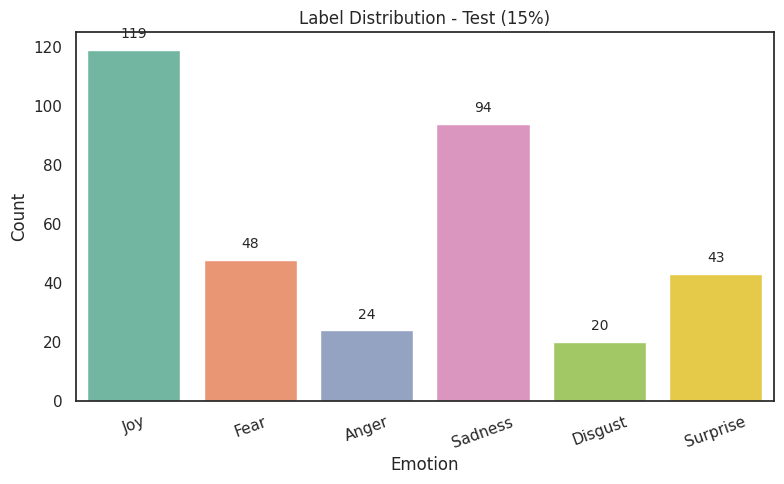

In [90]:
n_total = len(train_df) + len(val_df) + len(test_df)
split_props = {
    "train": (len(train_df), round(100*len(train_df)/n_total, 2)),
    "validation": (len(val_df), round(100*len(val_df)/n_total, 2)),
    "test": (len(test_df), round(100*len(test_df)/n_total, 2)),
    "total": n_total
}

plot_counts(train_df, "Label Distribution - Train (70%)", labels_ua)
plot_counts(val_df,   "Label Distribution - Validation (15%)", labels_ua)
plot_counts(test_df,  "Label Distribution - Test (15%)", labels_ua)

In [211]:
train_df

,text,label
1276,кроси страшні як я завтра зранку,4
113,"Хей, удачі :з Все вийде!)",0
111,"Одружується кращий друг, все дуже гарно (@ Пар...",0
354,"Яке щастя, що звідти прибрали постійно орущого...",0
1103,"Черговий бутік, а думала ресторанчик буде.",5
...,...,...
1802,"Якщо ти зрадиш, кохана,\nЯ вирву всі твої патл...",2
341,скачала всі муз рекомендації. сподобалися. дяк...,0
676,"Замість того, щоб творити щасливі миті, ми сум...",3
304,Абична) але на вулицю боїться ще.,0


In [213]:
val_df

,text,label
634,"Жалію, що не з твого міста(((",3
476,"Тепер я боюсь жарких маршруток, шоб не зомліти.",1
1154,"Хто ще не знав, що на ці вихідні в Черкасах тв...",5
1110,Вона стала дуже страшною( чому люди так себе з...,5
412,"Мене лякає, що вона ледь підстрибує з кожним у...",1
...,...,...
566,"Почала робити зауваження бидлу, яке недопалки ...",2
391,"Бо я прокинулась, глянула в дзеркало і злякалась.",1
1323,і доречі була в Копальні кави. там такиииииий ...,0
441,"Це настільки страшно, що здається, ніби все ві...",1


In [212]:
test_df

,text,label
1529,обговорюємо з Натою фізику і кабінет фізики :)...,0
509,"а я боюсь, шо беркут зараз з грушевського під...",1
1999,сумна історія про те що гичівський сумденьсум ...,3
1056,"Укр.виробник. але 1,5к. 1,5к, Карл!",5
770,сумна (насправді нє) історія про те як переста...,3
...,...,...
1275,"Думаю, зі сторони це виглялає бридко.",4
1047,"коли я вчора погоджувалась на всі activities, ...",5
2189,"В залі сидить чувіха, яка рже як кобила.",4
85,Субота явно найкращий день тижня,0


In [91]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

class_label = ClassLabel(num_classes=len(labels_ua), names=labels_ua)
def drop_unused(ds):
    cols = [c for c in ds.column_names if c not in ("text","label")]
    return ds.remove_columns(cols)

train_ds = drop_unused(train_ds).cast_column("label", class_label)
val_ds   = drop_unused(val_ds).cast_column("label", class_label)
test_ds  = drop_unused(test_ds).cast_column("label", class_label)

ua_ds_for_train = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})

Casting the dataset:   0%|          | 0/1619 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/347 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/348 [00:00<?, ? examples/s]

In [92]:
ua_ds_for_train

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1619
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 347
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 348
    })
})

### Tokenization

In [269]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
all_texts = []
for s in ["train","validation","test"]:
    if s in ua_ds_for_train:
        all_texts.extend(ua_ds_for_train[s]["text"])
lengths = pd.Series([len(tokenizer(t, add_special_tokens=True)["input_ids"]) for t in all_texts])
p95 = int(lengths.quantile(0.95))
p99 = int(lengths.quantile(0.99))
MAX_LEN = min(256, max(128, p99))
print({"p95": p95, "p99": p99, "MAX_LEN": MAX_LEN})

{'p95': 41, 'p99': 49, 'MAX_LEN': 128}


In [270]:
def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

In [271]:
train_tok = ua_ds_for_train["train"].map(tok, batched=True, remove_columns=["text"])
val_tok   = ua_ds_for_train["validation"].map(tok, batched=True, remove_columns=["text"])
test_tok  = ua_ds_for_train["test"].map(tok, batched=True, remove_columns=["text"])

Map:   0%|          | 0/1619 [00:00<?, ? examples/s]

Map:   0%|          | 0/347 [00:00<?, ? examples/s]

Map:   0%|          | 0/348 [00:00<?, ? examples/s]

In [272]:
y_train = np.array(ua_ds_for_train["train"]["label"])
counts = np.bincount(y_train, minlength=len(labels_list))
counts = np.maximum(counts, 1)
weights = counts.sum() / (len(counts) * counts)
class_weights = torch.tensor(weights, dtype=torch.float)

In [273]:
class_weights

tensor([0.4897, 1.2100, 2.3464, 0.6189, 2.8404, 1.3559])

In [274]:
train_tok[7]

{'label': 0,
 'input_ids': [0,
  744,
  2445,
  983,
  2744,
  24046,
  38,
  6,
  3321,
  419,
  751,
  189,
  21269,
  695,
  29,
  7878,
  743,
  8068,
  16,
  64947,
  68037,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [275]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)
labels_list = ua_ds_for_train["train"].features["label"].names

In [276]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(labels_list))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [277]:
def compute_metrics(eval_pred, label_list=labels_list):
    preds, y = eval_pred
    preds = np.argmax(preds, axis=1)
    per_class_f1 = {f"f1_{label_name}": score for label_name, score in zip(labels_list, f1_score(y, preds, average=None, zero_division=0))}
    return {
        "accuracy": accuracy_score(y, preds),
        "f1_macro": f1_score(y, preds, average="macro", zero_division=0),
        "precision_macro": precision_score(y, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(y, preds, average="macro", zero_division=0),
        **per_class_f1
    }

In [278]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        device = logits.device
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [279]:
args = TrainingArguments(
    output_dir="./emotion_ua_xlmr",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    logging_strategy="steps",
    logging_steps=10,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

In [280]:
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    processing_class=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [281]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Joy,F1 Fear,F1 Anger,F1 Sadness,F1 Disgust,F1 Surprise
1,1.811600,1.767252,0.172911,0.161543,0.337458,0.236039,0.000000,0.311688,0.141732,0.322981,0.146341,0.046512
2,1.726800,1.682947,0.475504,0.435266,0.526994,0.514573,0.712195,0.478873,0.274510,0.224299,0.393939,0.527778
3,1.549600,1.306814,0.590778,0.517161,0.577028,0.584991,0.756303,0.624113,0.294118,0.350000,0.411765,0.666667
4,1.134200,1.064054,0.639769,0.571275,0.592221,0.635854,0.796380,0.671533,0.297872,0.507692,0.430769,0.723404
5,0.831400,1.009297,0.731988,0.668710,0.661503,0.689631,0.818182,0.775862,0.391304,0.736264,0.583333,0.707317
6,0.770400,0.960984,0.708934,0.645350,0.637681,0.675708,0.812500,0.821429,0.312500,0.700637,0.521739,0.703297
7,0.609200,0.946934,0.734870,0.666978,0.657455,0.684934,0.819383,0.851852,0.350877,0.736842,0.523810,0.719101
8,0.622100,0.958413,0.734870,0.666921,0.657869,0.690072,0.823529,0.817391,0.379310,0.752941,0.523810,0.704545


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=208, training_loss=1.1596235976769373, metrics={'train_runtime': 193.823, 'train_samples_per_second': 83.53, 'train_steps_per_second': 1.341, 'total_flos': 318767408160552.0, 'train_loss': 1.1596235976769373, 'epoch': 8.0})

In [282]:
test_metrics = trainer.evaluate(eval_dataset=test_tok)
trainer.save_model("./emotion_ua_xlmr/best")
tokenizer.save_pretrained("./emotion_ua_xlmr/best")
print({"test": test_metrics})

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test': {'eval_loss': 1.002915620803833, 'eval_accuracy': 0.7126436781609196, 'eval_f1_macro': 0.6089597872783714, 'eval_precision_macro': 0.6264058067304501, 'eval_recall_macro': 0.6232199770061414, 'eval_f1_Joy': 0.8672566371681415, 'eval_f1_Fear': 0.7387387387387387, 'eval_f1_Anger': 0.28571428571428575, 'eval_f1_Sadness': 0.6984126984126984, 'eval_f1_Disgust': 0.36363636363636365, 'eval_f1_Surprise': 0.7000000000000001, 'eval_runtime': 0.8825, 'eval_samples_per_second': 394.351, 'eval_steps_per_second': 3.4, 'epoch': 8.0}}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

         Joy       0.92      0.82      0.87       119
        Fear       0.65      0.85      0.74        48
       Anger       0.45      0.21      0.29        24
     Sadness       0.69      0.70      0.70        94
     Disgust       0.29      0.50      0.36        20
    Surprise       0.76      0.65      0.70        43

    accuracy                           0.71       348
   macro avg       0.63      0.62      0.61       348
weighted avg       0.73      0.71      0.71       348



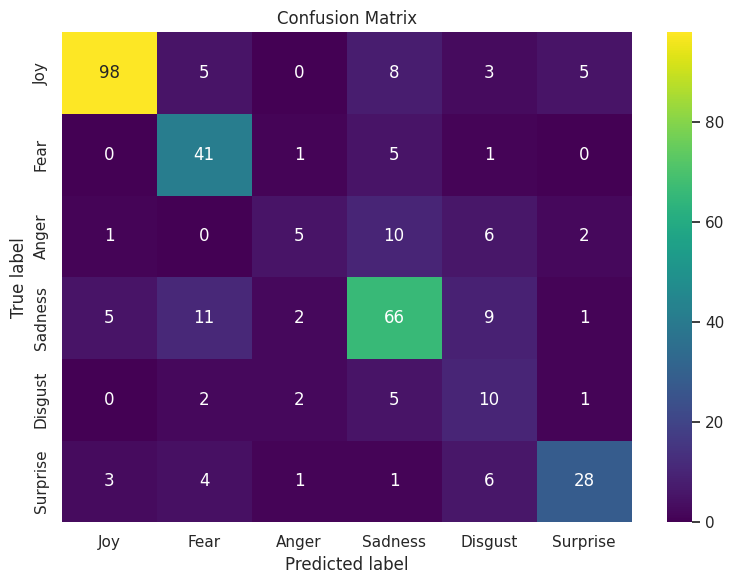

In [293]:
pred = trainer.predict(test_tok)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=labels_list))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=labels_list,
    yticklabels=labels_list
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()